**Comparing top performing model against triage tests and TPP**
---

In [58]:
import joblib

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

Loading in model from previous notebook

In [79]:
# Load model
lasso_on_rfe_no_demo = joblib.load("lasso_on_rfe_no_demo.pkl")

# Load test data
x_test_no_demo = joblib.load("x_test_no_demo.pkl")
y_test_no_demo = joblib.load("y_test_no_demo.pkl")

# Load feature list
overlap_features = joblib.load("overlap_features.pkl")

**Getting Sens and Spec of Model**

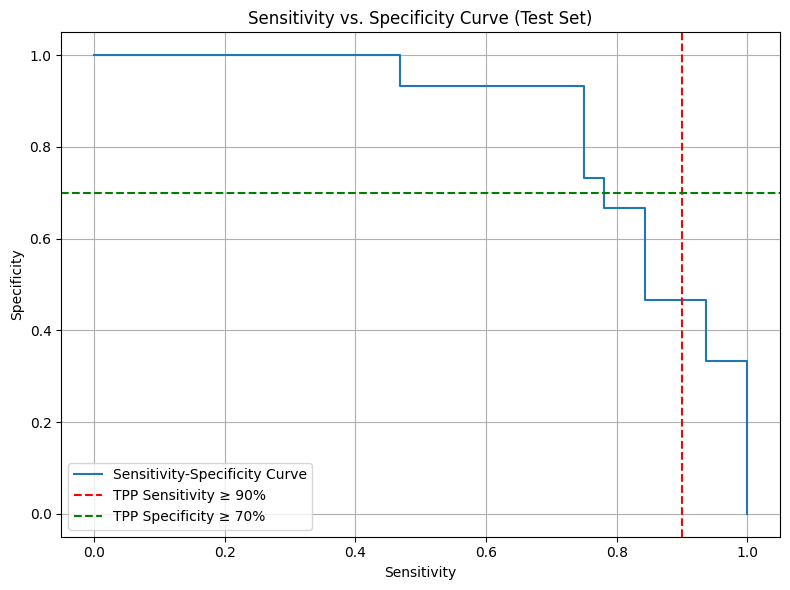

At sensitivity 0.938, specificity is 0.467, threshold = 0.324


In [84]:
# predicted probabilities from model
probs = lasso_on_rfe_no_demo.predict_proba(x_test_no_demo[overlap_features])[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_no_demo, probs)
specificity = 1 - fpr

# Sens. v Spec.
plt.figure(figsize=(8, 6))
plt.plot(tpr, specificity, label="Sensitivity-Specificity Curve")
plt.axvline(0.90, color="r", linestyle="--", label="TPP Sensitivity ≥ 90%")
plt.axhline(0.70, color="g", linestyle="--", label="TPP Specificity ≥ 70%")
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("Sensitivity vs. Specificity Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output_ModelSensVsSpec.pdf", bbox_inches="tight")
xlim = plt.xlim()
ylim = plt.ylim()
plt.show()

target_sens = 0.90
idx = np.where(tpr >= target_sens)[0][0]

print(f"At sensitivity {tpr[idx]:.3f}, specificity is {specificity[idx]:.3f}, threshold = {thresholds[idx]:.3f}")

In [78]:
# Youden's J  <- shows best balence of sens and spec
youden_j = tpr + specificity - 1
best_idx = np.argmax(youden_j)

print(f"Best threshold by Youden's J: {thresholds[best_idx]:.3f}")
print(f"Sensitivity: {tpr[best_idx]:.3f}")
print(f"Specificity: {specificity[best_idx]:.3f}")

Best threshold by Youden's J: 0.702
Sensitivity: 0.750
Specificity: 0.933


**Comparing with common triage tests:**

In [29]:
# test = {sensitivity : specificity}
models = [
    #  {"Name": "WHO TPP Minimum", "Sensitivity": .90, "Specificity": .70},
    {"Name": "CRP", "Sensitivity": .84, "Specificity": .61},
    {"Name": "CXR", "Sensitivity": .76, "Specificity": .82},
    {"Name": "CXR + CAD", "Sensitivity": .90, "Specificity": .74},
    {"Name": "Urine LAM", "Sensitivity": .42, "Specificity": .99},
    {"Name": "VOC Model (TPP threshold)", "Sensitivity": .938, "Specificity": .467},
    {"Name": "VOC Model (Optimized)", "Sensitivity": .75, "Specificity": .933}
]

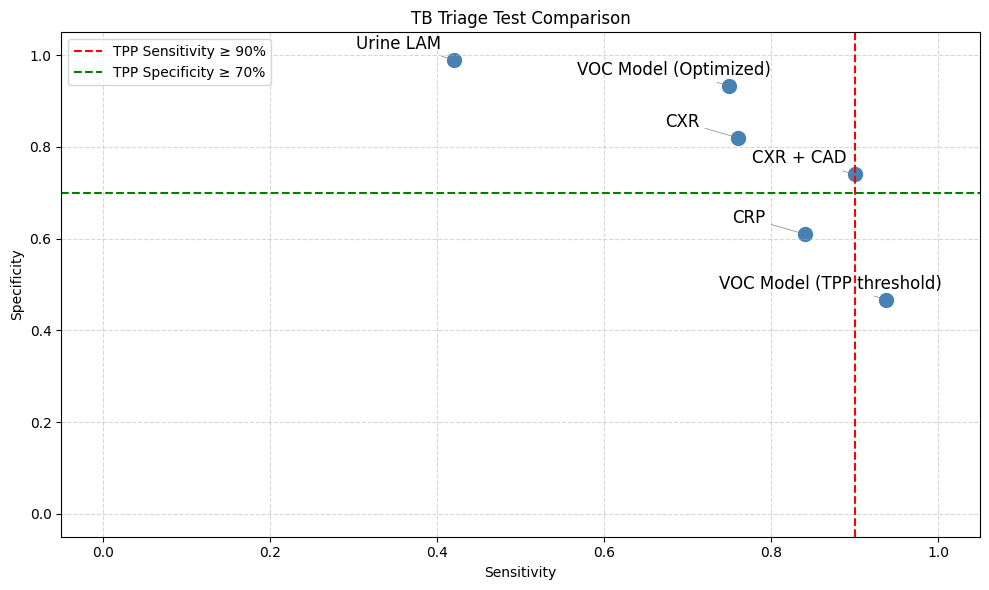

In [112]:
# Extract for plotting
names = [m["Name"] for m in models]
sensitivities = [m["Sensitivity"] for m in models]
specificities = [m["Specificity"] for m in models]


plt.figure(figsize=(10, 6))
plt.scatter(sensitivities, specificities, s=100, color="steelblue")

center_x, center_y = 0.5, 0.5

for i, name in enumerate(names):
    plt.annotate(
        name,
        xy=(sensitivities[i], specificities[i]),
        xytext=(-40, 8),
        textcoords="offset points",
        ha="center",
        fontsize=12,
        arrowprops=dict(arrowstyle="-", color="gray", lw=0.5)
    )

plt.axvline(.90, color="red", linestyle="--", label="TPP Sensitivity ≥ 90%")
plt.axhline(.70, color="green", linestyle="--", label="TPP Specificity ≥ 70%")
plt.xlabel("Sensitivity")
plt.ylabel("Specificity")
plt.title("TB Triage Test Comparison")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# axis limits from previous plot to make it match up nicely
plt.xlim(xlim)
plt.ylim(ylim)

plt.tight_layout()
plt.savefig("output_TriageSensVsSpec_MatchingLimits.pdf", bbox_inches="tight")
plt.show()

In [114]:
# redoing this to include the TPP now
models_data = [
    {"Model": "CRP", "Sensitivity": 0.84, "Specificity": 0.61},
    {"Model": "CXR", "Sensitivity": 0.76, "Specificity": 0.82},
    {"Model": "CXR + CAD", "Sensitivity": 0.90, "Specificity": 0.74},
    {"Model": "Urine LAM", "Sensitivity": 0.42, "Specificity": 0.99},
    {"Model": "VOC Model (TPP Threshold)", "Sensitivity": 0.938, "Specificity": 0.467},
    {"Model": "VOC Model (Optimized)", "Sensitivity": 0.75, "Specificity": 0.933},
    {"Model": "WHO TPP", "Sensitivity": 0.90, "Specificity": 0.70}
]

df = pd.DataFrame(models_data)
# to percent
df["Sensitivity"] = (df["Sensitivity"] * 100).round(1)
df["Specificity"] = (df["Specificity"] * 100).round(1)

# Reorder
df = df[["Model", "Sensitivity", "Specificity"]]
custom_order = [
    "WHO TPP",
    "VOC Model (TPP Threshold)",
    "VOC Model (Optimized)",
    "CXR + CAD",
    "CXR",
    "CRP",
    "Urine LAM"
]
df["Model"] = pd.Categorical(df["Model"], categories=custom_order, ordered=True)
df = df.sort_values("Model").reset_index(drop=True)
print(df)
df.to_excel("output_tb_triage_comparison_table.xlsx", index=False)

                       Model  Sensitivity  Specificity
0                    WHO TPP         90.0         70.0
1  VOC Model (TPP Threshold)         93.8         46.7
2      VOC Model (Optimized)         75.0         93.3
3                  CXR + CAD         90.0         74.0
4                        CXR         76.0         82.0
5                        CRP         84.0         61.0
6                  Urine LAM         42.0         99.0
